# 1. Introduction

本タスクは，顔の表情に示された感情に基づいて，各顔を以下の7つのカテゴリのいずれかに分類することです．データは，48×48ピクセルのグレースケールの顔画像で構成されています．これらの顔は全て中央に位置し，各画像内でほぼ同じスペースを占めるように登録されています．データは
[こちら](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data) から．

|  category  |  emotion  |
| :----: | :----: |
|  0  |  Angry  |
|  1  |  Disgust  |
|  2  |  Fear  |
|  3  |  Happy  |
|  4  |  Sad  |
|  5  |  Surprise  |
|  6  |  Neutral  |

# 2. Libraries

必要なライブラリをインポートします．

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'cv2'

In [2]:
import os
# os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

# 3. Load & Overview

データをデータフレームに落とし込み，応答変数の分布を確認します．

In [3]:
path = './challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv'
df = pd.read_csv(path, na_filter=False)
df

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...
28704,2,84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...
28705,0,114 112 113 113 111 111 112 113 115 113 114 11...
28706,4,74 81 87 89 95 100 98 93 105 120 127 133 146 1...
28707,0,222 227 203 90 86 90 84 77 94 87 99 119 134 14...


In [4]:
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [31]:
df['emotion'].value_counts(sort=False).rename(index=dict(zip(list(range(7)), emotions)))

Angry       3995
Disgust      436
Fear        4097
Happy       7215
Sad         4830
Surprise    3171
Neutral     4965
Name: emotion, dtype: int64

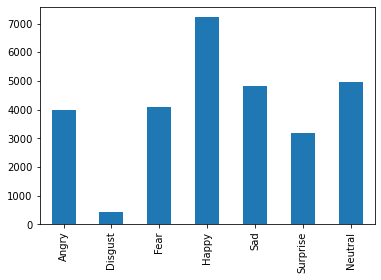

In [32]:
df['emotion'].value_counts(sort=False).rename(index=dict(zip(list(range(7)), emotions))).plot(kind='bar')

# 4. Functions

サンプル表示，学習データ成形に必要な関数を定義します．

In [7]:
def prepare_df(df):
    img_array = np.zeros(shape=(len(df), 48, 48))
    img_label = np.array(list(map(int, df['emotion'])))
    for i, row in enumerate(df.index):
        image = np.fromstring(df.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        img_array[i] = image
        
    return img_array, img_label

def plot_examples(label=0):
    fig, ax = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    ax = ax.ravel()
    for i in range(5):
        idx = df[df['emotion']==label].index[i]
        ax[i].imshow(images[idx][:,:,0], cmap='gray')
        ax[i].set_title(emotions[labels[idx].argmax()])
        ax[i].set_xticklabels([])
        ax[i].set_yticklabels([])

In [8]:
img_array, img_label = prepare_df(df)
images = img_array.reshape((img_array.shape[0], 48, 48, 1)).astype('float32')/255
labels = to_categorical(img_label)

In [9]:
def gray_to_rgb(img):
  w, h = img.shape
  ret = np.empty((w, h, 3), dtype=np.uint8)
  ret[:, :, 2] = ret[:, :, 1] = ret[:, :, 0] = img
  return ret

def convert_to_image(pixels, mode='save', t='gray'):
  if type(pixels) == str:
      pixels = np.array([int(i) for i in pixels.split()])
  if mode == 'show':
    if t == 'gray':
      return pixels.reshape(48, 48)
    else:
      return gray_to_rgb(pixels.reshape(48, 48))
  else:
      return pixels

In [10]:
df['pixels'] = df['pixels'].apply(lambda x : convert_to_image(x, mode='show', t='gray'))
df

,emotion,pixels
0,0,"[[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, ..."
1,0,"[[151, 150, 147, 155, 148, 133, 111, 140, 170,..."
2,2,"[[231, 212, 156, 164, 174, 138, 161, 173, 182,..."
3,4,"[[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, ..."
4,6,"[[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 2..."
...,...,...
28704,2,"[[84, 85, 85, 85, 85, 85, 85, 85, 86, 86, 86, ..."
28705,0,"[[114, 112, 113, 113, 111, 111, 112, 113, 115,..."
28706,4,"[[74, 81, 87, 89, 95, 100, 98, 93, 105, 120, 1..."
28707,0,"[[222, 227, 203, 90, 86, 90, 84, 77, 94, 87, 9..."


In [11]:
X_train, X_val, y_train, y_val = train_test_split(df["pixels"],  df["emotion"], test_size=0.2, random_state=1)

X_train = np.array(list(X_train[:]), dtype=np.float)
X_val = np.array(list(X_val[:]), dtype=np.float)

y_train = np.array(list(y_train[:]), dtype=np.float)
y_val = np.array(list(y_val[:]), dtype=np.float)

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1) 
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)

# 5. Data Examples

各表情のサンプルを以下に示します．

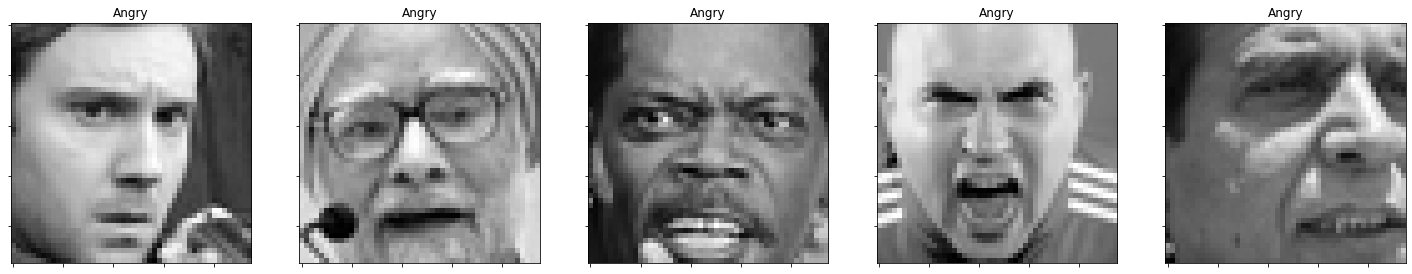

In [33]:
# Angry
plot_examples(label=0)

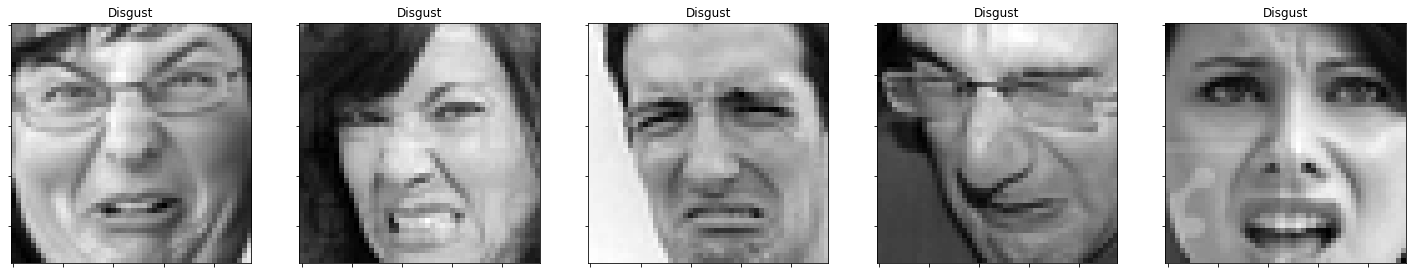

In [34]:
# Disgust
plot_examples(label=1)

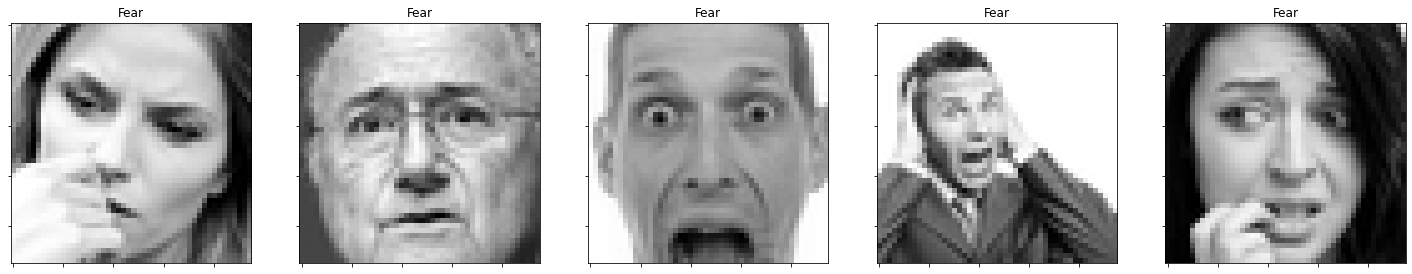

In [35]:
# Fear
plot_examples(label=2)

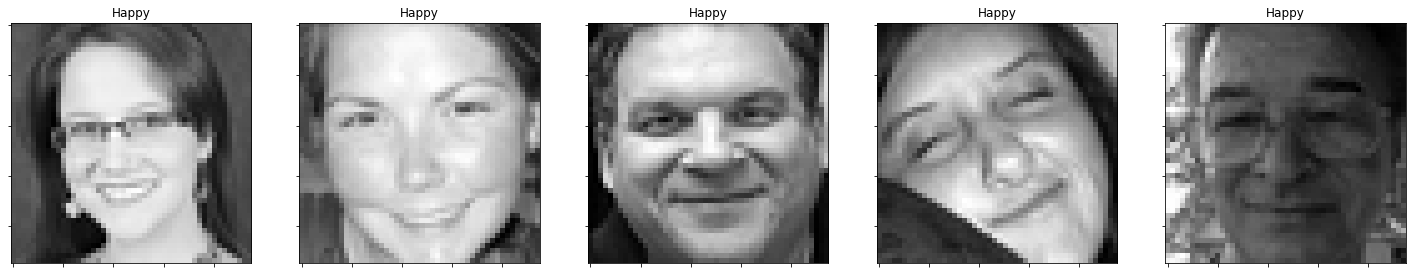

In [36]:
# Happy
plot_examples(label=3)

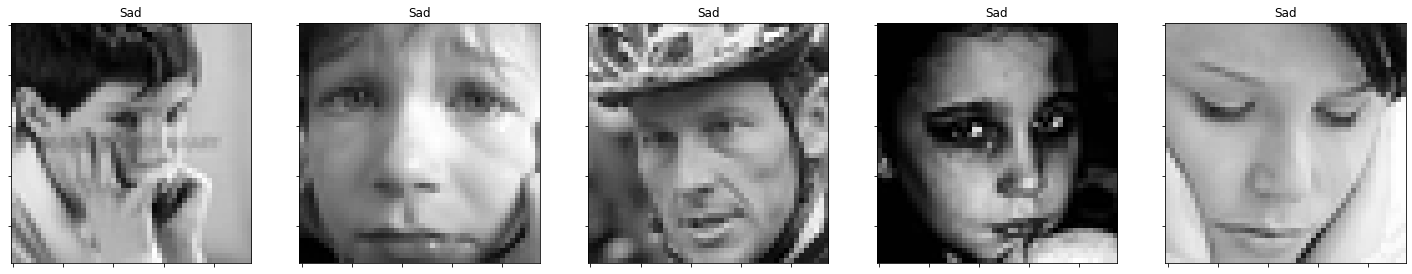

In [37]:
# Sad
plot_examples(label=4)

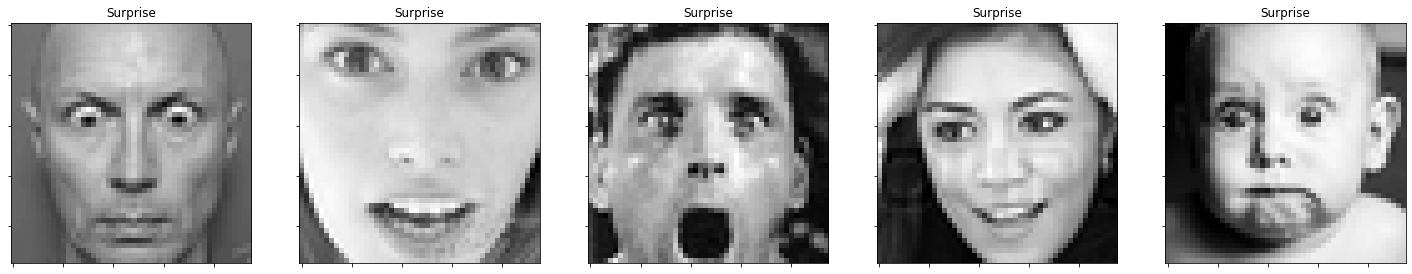

In [38]:
# Surprise
plot_examples(label=5)

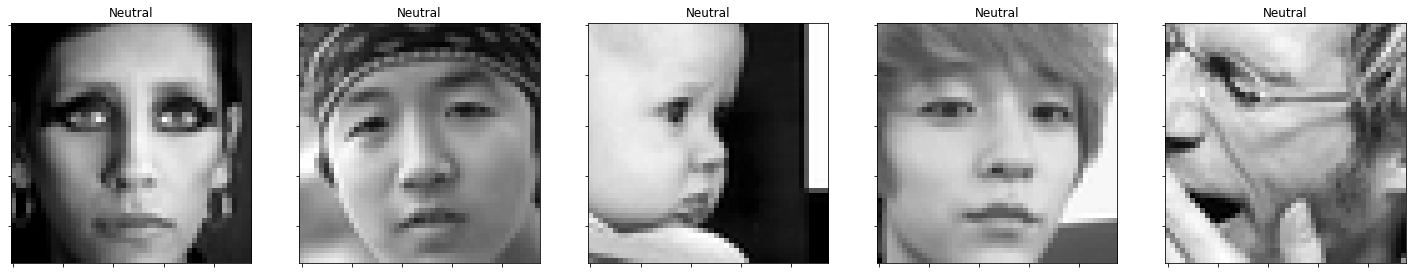

In [39]:
# Neutral
plot_examples(label=6)

# 6. Model

以下のCNNモデルを構成し，学習を行ないます．

In [19]:
tf.compat.v1.set_random_seed(0)

In [20]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), 
                        activation='relu', input_shape=(48, 48, 1)),
    keras.layers.BatchNormalization(axis=1),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.2),#add

    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(axis=1),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.2),#add

    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(axis=1),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.2),#add
    
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(axis=1),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.2),#add
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(7, activation='softmax')
])

In [21]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 32)        184       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 21, 64)        84        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0

In [23]:
fitting = model.fit(X_train, y_train, epochs=80, batch_size=128, validation_data=(X_val,y_val))

Epoch 1/80
180/180 [==============================] - 32s 179ms/step - loss: 1.8266 - accuracy: 0.2309 - val_loss: 1.7893 - val_accuracy: 0.2572
Epoch 2/80
180/180 [==============================] - 35s 193ms/step - loss: 1.8016 - accuracy: 0.2455 - val_loss: 1.7915 - val_accuracy: 0.2605
Epoch 3/80
180/180 [==============================] - 34s 188ms/step - loss: 1.7543 - accuracy: 0.2753 - val_loss: 1.6688 - val_accuracy: 0.3305
Epoch 4/80
180/180 [==============================] - 34s 188ms/step - loss: 1.6427 - accuracy: 0.3420 - val_loss: 1.5759 - val_accuracy: 0.3664
Epoch 5/80
180/180 [==============================] - 34s 187ms/step - loss: 1.5232 - accuracy: 0.4088 - val_loss: 1.3716 - val_accuracy: 0.4754
Epoch 6/80
180/180 [==============================] - 34s 189ms/step - loss: 1.4359 - accuracy: 0.4466 - val_loss: 1.3731 - val_accuracy: 0.4692
Epoch 7/80
180/180 [==============================] - 34s 187ms/step - loss: 1.3808 - accuracy: 0.4712 - val_loss: 1.2523 - val_ac

In [41]:
model.save('face_emotion.h5')

# 7. Analyze Convergence

エポックごとのLossとAccuracyの遷移を表示します．

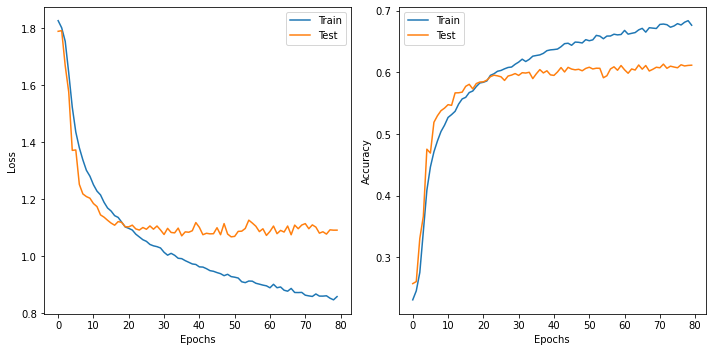

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(fitting.history['loss'])
ax[0].plot(fitting.history['val_loss'])
ax[1].plot(fitting.history['accuracy'])
ax[1].plot(fitting.history['val_accuracy'])

ax[0].legend(['Train', 'Test'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].legend(['Train', 'Test'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
    
plt.tight_layout()

# 8. Emotions from My Face?

学習したモデルで，実際に自分の顔写真を使って予測してみました．

In [46]:
def predict(img_path):
    gray = Image.open(img_path).convert('L')
    img_resize = gray.resize((48, 48))
    plt.imshow(img_resize, cmap='gray')
    img = np.array(img_resize).reshape(1, 48, 48, 1)

    pre = model.predict(img).reshape(7)
    arg = np.argsort(pre)[::-1]
    for i in range(3):
        print('{}.{}: {}'.format(i + 1, emotions[arg[i]], pre[arg[i]]))

1.Neutral: 0.9488288164138794
2.Sad: 0.027489986270666122
3.Happy: 0.00911007635295391


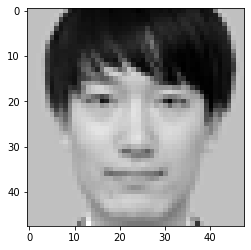

In [47]:
predict('./img/square/test.jpg')

1.Surprise: 0.7190713286399841
2.Fear: 0.20108360052108765
3.Angry: 0.03022819012403488


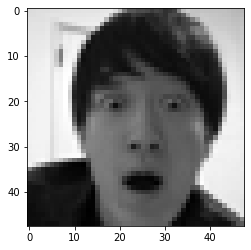

In [48]:
predict('./img/square/test2.jpg')

1.Happy: 0.9857215881347656
2.Neutral: 0.01329176127910614
3.Sad: 0.00047593427007086575


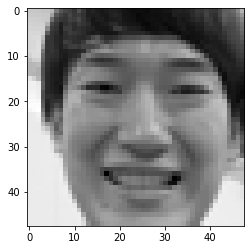

In [49]:
predict('./img/square/test3.jpg')